## Model with one clue at a time

### Data Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

## Data pre-processing

In [2]:

clues = pd.read_csv('clues.csv', index_col=0)

labels = pd.read_csv('selected_labels.csv')
labels = labels.drop(columns=['Ball', 'Gate', 'referee Image'])
LABELS = [
    'Start/Restar the game',
    'The joy of the players',
    'yellow card',
    'Red Card',
    'Stadium View',
    'Penalty Image',
    'Free Kick',
    'Generic Moment'
]
# visualize the mapping from label names to indices
label_to_index = {label: idx for idx, label in enumerate(LABELS)}
label_to_index
labels['label'] = labels[LABELS].idxmax(axis=1).map({label: idx for idx, label in enumerate(LABELS)})
labels['label'] = labels['label'].astype(int)
labels = labels.drop(columns=LABELS)

In [3]:
# data normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [4]:
batch_size = 32
learning_rate = 1e-3
num_epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
class SingleClueDataset(Dataset):
    def __init__(self, main_df, clues_df, image_folder, clue_column, transform=None):

        self.main_df = main_df
        self.clues_df = clues_df
        self.image_folder = image_folder
        self.clue_column = clue_column
        self.transform = transform
        
    def __len__(self):
        return len(self.main_df)
    
    def __getitem__(self, idx):

        main_row = self.main_df.iloc[idx]
        
        clues_row = self.clues_df.iloc[idx]
        
        img_path = os.path.join(self.image_folder, str(main_row['Image Number']) + '.jpg')
        image = Image.open(img_path).convert('RGB')
        
        label = main_row['label']
        
        binary_feature = torch.tensor([float(clues_row[self.clue_column])], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label, binary_feature
    


## Fine-tuning and evaluation functions

In [6]:
class SingleClueResNet(nn.Module):
    def __init__(self, num_classes=8, pretrained_path=None, clue_name=None):

        super(SingleClueResNet, self).__init__()
        
        self.clue_name = clue_name
        
        self.resnet = models.resnet18(pretrained=False)
        fc_input_size = self.resnet.fc.in_features  # 512 for ResNet18
        self.resnet.fc = nn.Identity()
        self.fc = nn.Linear(fc_input_size + 1, num_classes)

        if pretrained_path:
            self.load_pretrained_weights(pretrained_path)
    
    def load_pretrained_weights(self, pretrained_path):

        pretrained_dict = torch.load(pretrained_path)
        model_dict = self.resnet.state_dict()
        
        pretrained_dict = {k: v for k, v in pretrained_dict.items() 
                          if k in model_dict and 'fc' not in k}
        
        model_dict.update(pretrained_dict)
        self.resnet.load_state_dict(model_dict, strict=False)

        if 'fc.weight' in pretrained_dict:
            with torch.no_grad():
                original_fc_weight = pretrained_dict['fc.weight'] # shape: [num_classes, 512]
                original_fc_bias = pretrained_dict['fc.bias'] # shape: [num_classes]

                self.fc.weight.data[:, :fc_input_size] = original_fc_weight
                self.fc.bias.data = original_fc_bias
    
    def forward(self, x, binary_feature):
        features = self.resnet(x) 
        combined_features = torch.cat((features, binary_feature), dim=1)
        
        return self.fc(combined_features)


In [7]:
def train_single_clue(clue_name, train_df, val_df, test_df, clues_df, pretrained_path,
                                        num_classes=8, batch_size=32, num_epochs=10,
                                        learning_rate=1e-3):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = SingleClueResNet(num_classes=num_classes, pretrained_path=pretrained_path, clue_name=clue_name)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    print(f"\n––– Training with clue: {clue_name} –––\n")
    

    train_acc, val_acc = [], []
    train_loss, val_loss = [], []
    best_val_loss = float('inf')
    

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels, binary_feature in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            binary_feature = binary_feature.to(device)
            
            optimizer.zero_grad()
            outputs = model(images, binary_feature)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total * 100
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        

        model.eval()
        val_running_loss = 0.0
        val_correct, val_total = 0, 0
        
        with torch.no_grad():
            for images, labels, binary_feature in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                binary_feature = binary_feature.to(device)
                
                outputs = model(images, binary_feature)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total * 100
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)
        
        print(f"[{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.2f}%")
        

        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            model_path = f'resnet18_clue_{clue_name}.pth'
            torch.save(model.state_dict(), model_path)
            print(f"Saved new best model: {model_path}!\n")
    
    print("Training complete.")
    
    
    return {
        'clue_name': clue_name,
        'train_acc': train_acc,
        'val_acc': val_acc,
    }


In [13]:
def evaluate(clue_name, num_classes=8):

    best_model = SingleClueResNet(num_classes=num_classes, clue_name=clue_name)
    best_model.load_state_dict(torch.load(f'resnet18_clue_{clue_name}.pth'))
    best_model = best_model.to(device)
    best_model.eval()
    
    print(f"\n––– Evaluating model with clue: {clue_name} –––\n")
    test_correct, test_total = 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, binary_feature in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            binary_feature = binary_feature.to(device)
            
            outputs = best_model(images, binary_feature)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    
    test_acc = test_correct / test_total * 100
    print(f"\nTest Accuracy with {clue_name}: {test_acc:.2f}%")
    
    report = classification_report(all_labels, all_preds, 
                               target_names=LABELS, 
                               digits=3)
    print(f"All metrics adding {clue_name} clue:\n{report}")
    

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    for i in range(len(all_labels)):
        label = all_labels[i]
        pred = all_preds[i]
        class_total[label] += 1
        if pred == label:
            class_correct[label] += 1
    
    class_accuracies = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]
    
    print(f"\nPer-Class Accuracy with {clue_name}:")
    print(f"{'Class':<25}{'Accuracy':>10}{'Support':>10}")
    print("-" * 45)
    for i, (acc, total) in enumerate(zip(class_accuracies, class_total)):
        print(f"{LABELS[i]:<25}{acc:>9.2f}%{total:>10}")
        
    # confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f"Confusion Matrix (Percentages) for {clue_name} Mask Model on Test Set")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Overall weighted metrics
    weighted_precision = precision_score(all_labels, all_preds, average='weighted')
    weighted_recall = recall_score(all_labels, all_preds, average='weighted')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\nOverall weighted metrics with {clue_name}:")
    print(f"Accuracy: {test_acc/100:.3f}%")
    print(f"Weighted Precision: {weighted_precision:.3f}")
    print(f"Weighted Recall: {weighted_recall:.3f}")
    print(f"Weighted F1 Score: {weighted_f1:.3f}")
    
    return test_acc
    

## Model training

In [10]:
clue_names=['Ball', 'Gate', 'Referee']
image_folder = 'data/selected_images'
pretrained_path = 'resnet18_baseline.pth'

train_df, test_df = train_test_split(labels, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)


for clue_name in clue_names:
    
    train_dataset = SingleClueDataset(train_df, clues, image_folder, clue_name, transform)
    val_dataset = SingleClueDataset(val_df, clues, image_folder, clue_name, transform)
    test_dataset = SingleClueDataset(test_df, clues, image_folder, clue_name, transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
for clue_name in clue_names:
    
    train_single_clue(
        clue_name=clue_name,
        train_df=train_loader,
        val_df=val_loader,
        test_df=test_loader,
        clues_df=clues,
        pretrained_path=pretrained_path
    )



––– Training with clue: Ball –––

[1/10] Train Loss: 0.4780, Acc: 83.89%, Val Loss: 0.5109, Acc: 82.38%
Saved new best model: resnet18_clue_Ball.pth!

[2/10] Train Loss: 0.2998, Acc: 89.81%, Val Loss: 0.5782, Acc: 82.00%
[3/10] Train Loss: 0.2558, Acc: 91.31%, Val Loss: 0.6562, Acc: 81.25%
[4/10] Train Loss: 0.1542, Acc: 94.97%, Val Loss: 0.6029, Acc: 82.00%
[5/10] Train Loss: 0.1334, Acc: 95.56%, Val Loss: 0.6181, Acc: 80.75%
[6/10] Train Loss: 0.1126, Acc: 96.11%, Val Loss: 0.6735, Acc: 83.00%
[7/10] Train Loss: 0.0981, Acc: 96.56%, Val Loss: 0.6871, Acc: 84.38%
[8/10] Train Loss: 0.0784, Acc: 97.29%, Val Loss: 0.7024, Acc: 82.88%
[9/10] Train Loss: 0.0759, Acc: 97.47%, Val Loss: 0.7117, Acc: 82.25%
[10/10] Train Loss: 0.0557, Acc: 98.03%, Val Loss: 0.8629, Acc: 83.62%
Training complete.

––– Training with clue: Gate –––

[1/10] Train Loss: 0.4756, Acc: 84.08%, Val Loss: 0.5984, Acc: 80.88%
Saved new best model: resnet18_clue_Gate.pth!

[2/10] Train Loss: 0.2998, Acc: 89.64%, Val Lo

## Model evaluation


––– Evaluating model with clue: Ball –––


Test Accuracy with Ball: 80.55%
All metrics adding Ball clue:
                        precision    recall  f1-score   support

 Start/Restar the game      1.000     0.656     0.792        64
The joy of the players      0.726     0.743     0.735       257
           yellow card      1.000     0.661     0.796       115
              Red Card      0.750     0.231     0.353        13
          Stadium View      0.853     0.938     0.893       660
         Penalty Image      0.947     0.750     0.837        72
             Free Kick      0.804     0.893     0.846       431
        Generic Moment      0.683     0.621     0.650       388

              accuracy                          0.805      2000
             macro avg      0.845     0.687     0.738      2000
          weighted avg      0.809     0.805     0.801      2000


Per-Class Accuracy with Ball:
Class                      Accuracy   Support
---------------------------------------------


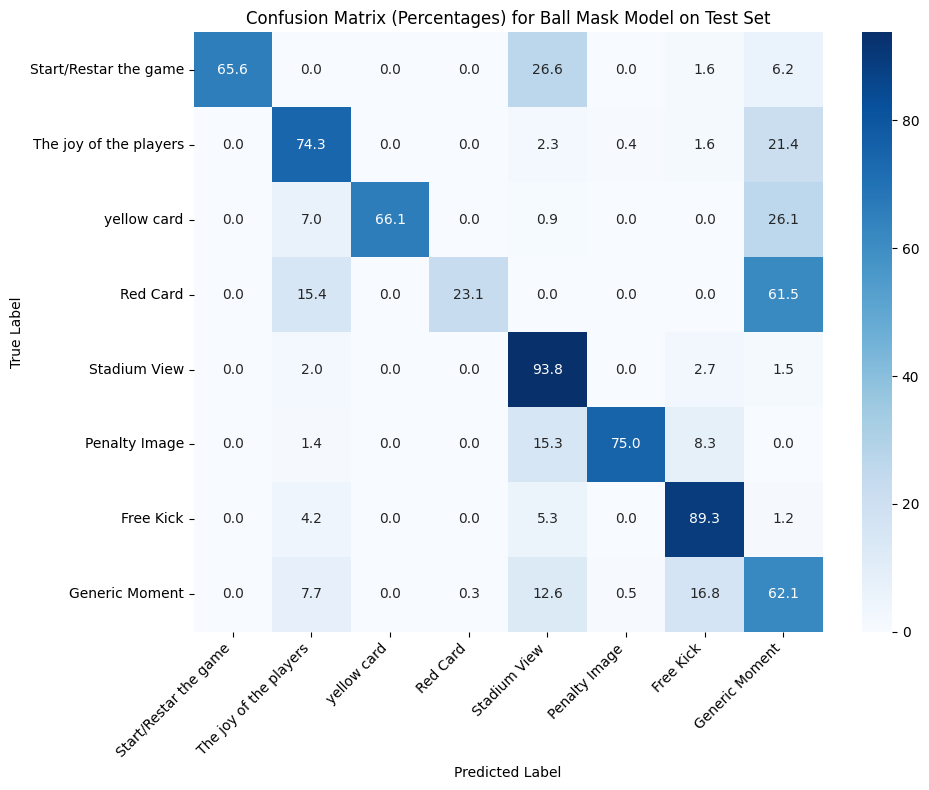


Overall weighted metrics with Ball:
Accuracy: 0.805%
Weighted Precision: 0.809
Weighted Recall: 0.805
Weighted F1 Score: 0.801

––– Evaluating model with clue: Gate –––


Test Accuracy with Gate: 82.00%
All metrics adding Gate clue:
                        precision    recall  f1-score   support

 Start/Restar the game      0.853     0.906     0.879        64
The joy of the players      0.771     0.669     0.717       257
           yellow card      0.953     0.713     0.816       115
              Red Card      0.875     0.538     0.667        13
          Stadium View      0.893     0.895     0.894       660
         Penalty Image      0.981     0.722     0.832        72
             Free Kick      0.896     0.840     0.867       431
        Generic Moment      0.637     0.814     0.715       388

              accuracy                          0.820      2000
             macro avg      0.857     0.762     0.798      2000
          weighted avg      0.834     0.820     0.822      2

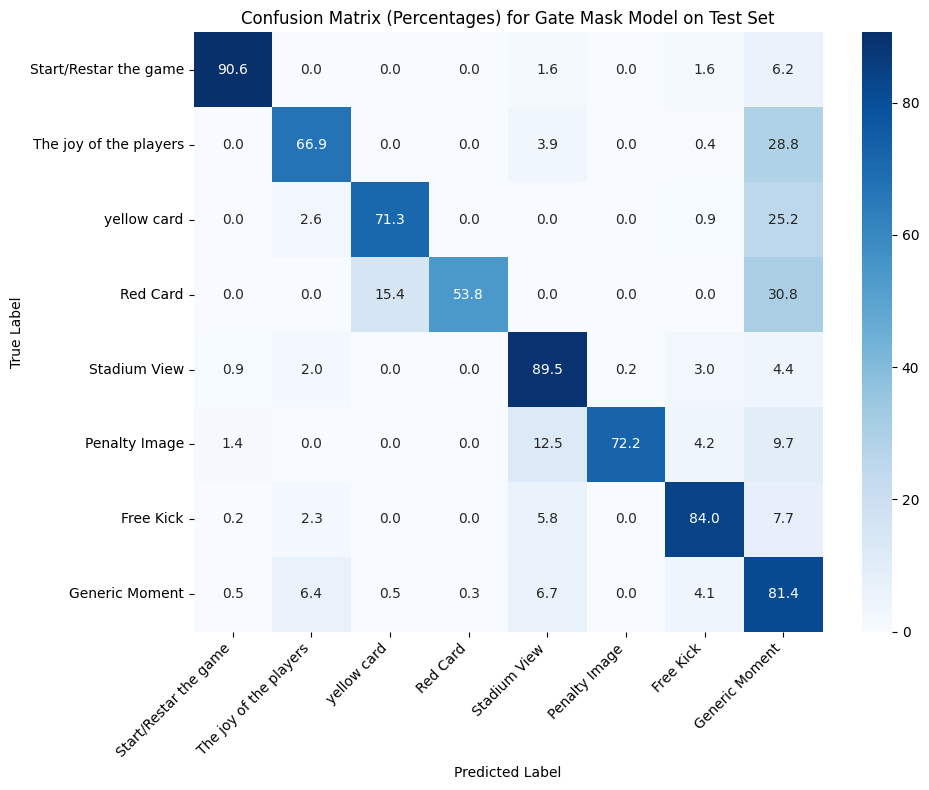


Overall weighted metrics with Gate:
Accuracy: 0.820%
Weighted Precision: 0.834
Weighted Recall: 0.820
Weighted F1 Score: 0.822

––– Evaluating model with clue: Referee –––


Test Accuracy with Referee: 83.25%
All metrics adding Referee clue:
                        precision    recall  f1-score   support

 Start/Restar the game      0.931     0.844     0.885        64
The joy of the players      0.812     0.689     0.745       257
           yellow card      0.873     0.835     0.853       115
              Red Card      0.778     0.538     0.636        13
          Stadium View      0.865     0.945     0.904       660
         Penalty Image      0.938     0.833     0.882        72
             Free Kick      0.859     0.835     0.847       431
        Generic Moment      0.716     0.740     0.728       388

              accuracy                          0.833      2000
             macro avg      0.846     0.782     0.810      2000
          weighted avg      0.833     0.833     0.8

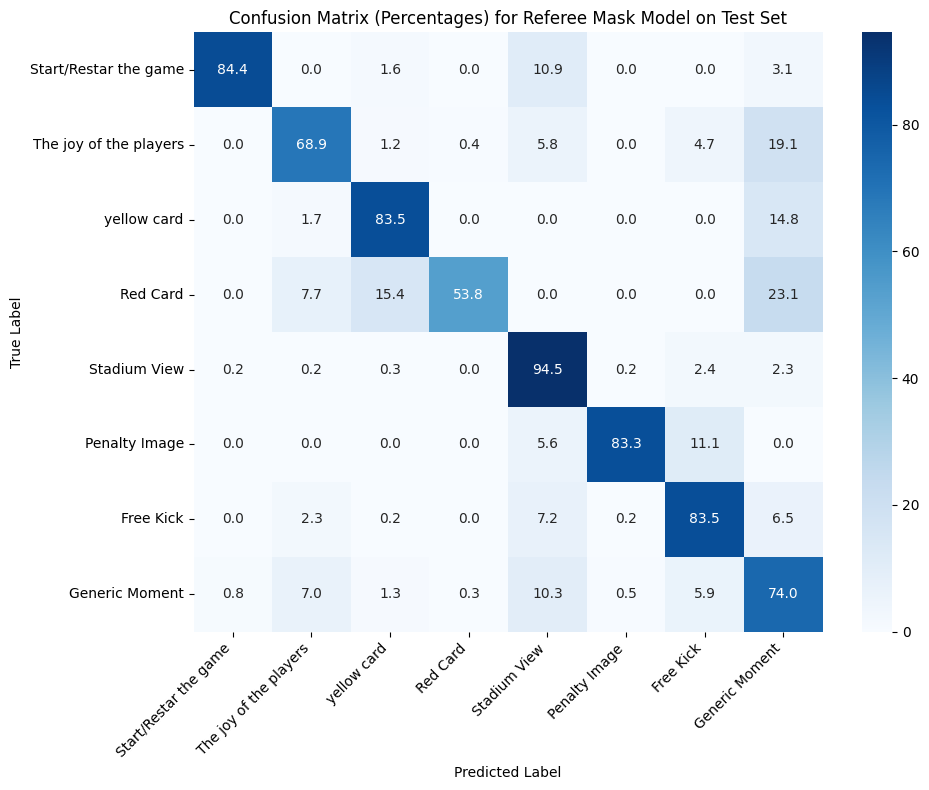


Overall weighted metrics with Referee:
Accuracy: 0.833%
Weighted Precision: 0.833
Weighted Recall: 0.833
Weighted F1 Score: 0.831


In [14]:
results = []
num_classes = len(LABELS)
for clue_name in clue_names:
    result = evaluate(
        clue_name=clue_name,
        num_classes=num_classes
    )
    results.append(result)